In [1]:
import omnitool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.table import Table

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We want to see how the choice of the length scale L might change distance estimates.
We will be using the [Bailer-Jones et al. 2018](http://adsabs.harvard.edu/abs/2018arXiv180410121B) method (see also: [Bailer-Jones 2015](https://arxiv.org/pdf/1507.02105.pdf).


I'll use stars from Megan Bedell's [catalogue](https://gaia-kepler.fun/) of Kepler long cadence stars.

Please note that I am excluding any stars here with a modality flag of 2, indicating that the *median* of the posterior was used and not the *mode*, which is what this code compares.

In [2]:
data = Table.read('/home/oliver/PhD/Gaia_Project/data/KepxDR2/kepler_dr2_1arcsec.fits', format='fits')
kdf = data.to_pandas()[:]
kdf = kdf[kdf.r_modality_flag == 1]
kdf['f'] = np.abs(kdf.parallax_error / kdf.parallax)
kdf.rename(columns={'kepid':'KICID'},inplace=True)
kdf.head(2)
print(len(kdf))

195829


### First, lets calculate the mode using the L given in the catalogue.

**Note that I subtract the Gaia parallax zero-point magnitude (-0.029mas) before I pass the parallax values! If you don't do this it has a huge compound effect at larger distances.**

In [3]:
bj = omnitool.bailerjones(kdf.parallax+0.029, kdf.parallax_error, kdf.r_length_prior)
r_est = bj()

/usr/local/lib/python2.7/dist-packages/omnitool-0.3-py2.7.egg/omnitool/gaia_tools.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(roots[0])


Lets quickly make sure they're the same as the quoted value in the catalogue.

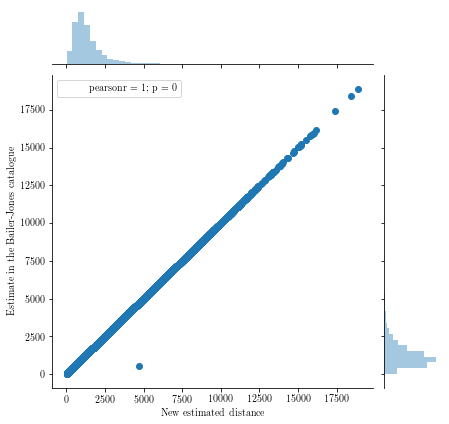

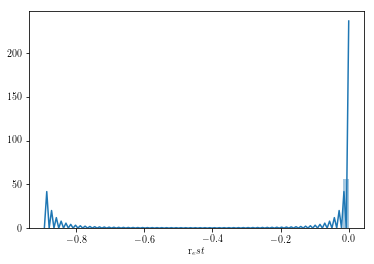

In [4]:
sns.jointplot(kdf.r_est, r_est).set_axis_labels('New estimated distance','Estimate in the Bailer-Jones catalogue')
plt.show()
sns.distplot((r_est-kdf.r_est)/kdf.r_est,norm_hist=False)
plt.show()

We find closely correlated data, so our method works (bar a single outlier, 1 in almost 200.000).

### Now we want to do the same, but with a different, single choice of L (for example), and see how it changes the data!

In [10]:
bj = omnitool.bailerjones(kdf.parallax+0.029, kdf.parallax_error,500.)
r_est = bj()

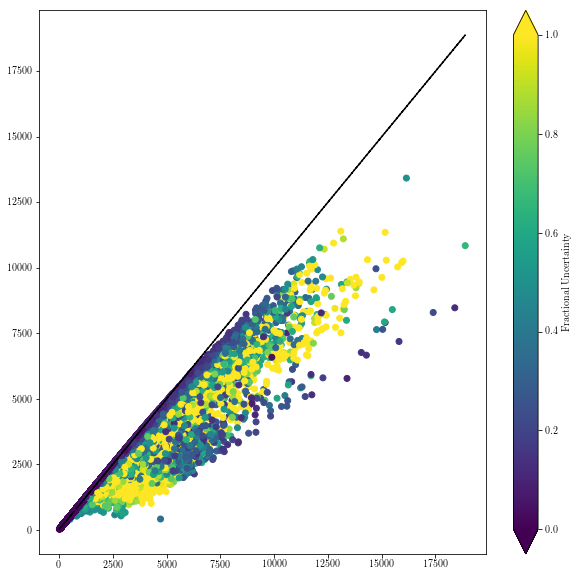

In [11]:
fig = plt.figure(figsize=(10,10))
c = plt.scatter(kdf.r_est, r_est,vmin=0., vmax=1., c=kdf.f)
plt.plot(kdf.r_est,kdf.r_est,c='k',linestyle='-.')
fig.colorbar(c,extend='both',label='Fractional Uncertainty')
plt.show()

The new distance estimates are significantly lower, and stars with large fractional uncertainties are more likely to have large residuals due to the prior dominating, and the lower L causing it to have a mode at a lower distance value.